# CPM to Noise Classification with Python

This notebook uses Python and TesnorFlow for a mechanism to classify data into normal CPM data, Gaussian random data, and exponential random data.

Much of the code is based on https://erichizdepski.wordpress.com/2019/05/23/using-machine-learning-to-categorize-radio-signals/

### Import necessary pacakages.

In [1]:
%matplotlib inline
import os
import sys
import urllib3
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["KERAS_BACKEND"] = "theano" # "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cpu"
import theano as th
import theano.tensor as T
import keras
import keras.models as models
from keras.utils import np_utils
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.recurrent import LSTM
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Make datasets of CPM logs and corresponding labels.

In [2]:
def urltodf(xpat):
    xpq = urllib3.PoolManager()
    xpq = xpq.request('GET', xpat)
    xpq = xpq.data.decode('utf-8')
    xpq = xpq.split(',')
    xpq = list(filter(None, xpq))
    xpq = pd.DataFrame(xpq, columns=['Rec'])
    xpq['Ind'] = xpq['Rec'].apply(lambda x: len(x))
    xpq = xpq[xpq['Ind'] == 13]
    xpq['Cpm'] = xpq['Rec'].apply(lambda x: int(x[11:]))
    xpq = xpq.dropna()
    xpq = xpq['Cpm'].tolist()
    xxa = [[xpq[x:x+10],xpq[x+11:x+20],xpq[x+21:x+30],xpq[x+31:x+40],xpq[x+41:x+50],xpq[x+51:x+60],
            xpq[x+61:x+70],xpq[x+71:x+80],xpq[x+81:x+90],xpq[x+91:x+100]] for x in range(0,len(xpq)-100,100)]
    xya = [[1,0,0] for x in range(0,len(xpq),100)]
    return xxa, xya

In [3]:
xa1, ya1 = urltodf("https://lipy.us/data/2022_2_GMC_31164B313435D3_Montclair_3407_w11772.txt")
xa2, ya2 = urltodf("https://lipy.us/data/2022_1_GMC_37074B313530AA_YorbaLinda_3389_w11780.txt")

In [4]:
xa1[:2]

[[[22, 22, 20, 20, 20, 22, 17, 17, 15, 15],
  [14, 14, 14, 13, 14, 17, 18, 20, 20],
  [20, 19, 20, 20, 20, 20, 19, 18, 18],
  [17, 15, 17, 17, 18, 20, 22, 21, 19],
  [17, 18, 20, 18, 19, 18, 17, 16, 14],
  [14, 14, 13, 13, 13, 15, 14, 16, 17],
  [17, 18, 18, 18, 18, 17, 16, 17, 16],
  [13, 14, 16, 15, 17, 16, 20, 20, 21],
  [20, 19, 21, 19, 18, 18, 18, 19, 19],
  [17, 19, 19, 19, 19, 22, 23, 25, 22]],
 [[22, 21, 23, 22, 21, 21, 22, 22, 20, 19],
  [19, 19, 18, 17, 19, 18, 19, 18, 15],
  [12, 14, 13, 13, 12, 11, 10, 12, 10],
  [12, 12, 12, 14, 16, 16, 17, 18, 16],
  [15, 17, 15, 17, 19, 18, 18, 20, 19],
  [19, 21, 21, 22, 23, 25, 23, 22, 21],
  [20, 19, 18, 17, 18, 14, 10, 10, 11],
  [14, 16, 18, 18, 19, 19, 19, 20, 18],
  [23, 23, 22, 23, 21, 23, 20, 23, 25],
  [29, 25, 23, 22, 21, 17, 17, 17, 20]]]

In [5]:
ya1[:2]

[[1, 0, 0], [1, 0, 0]]

In [6]:
len(ya1 + ya2)

1016

### Make datasets of Gaussian and exponential random values and corresponding labels.

In [7]:
xa3 = [1 for i in range(1000)]
xa4 = [1 for i in range(1000)]
for i in range(1000):
    z = np.random.normal(loc=15, scale=1, size=100).astype(int).tolist()
    xa3[i] = [z[:10],z[11:20],z[21:30],z[31:40],z[41:50],z[51:60],z[61:70],z[71:80],z[81:90],z[91:100]]
    z = np.random.exponential(scale=20, size=100).astype(int).tolist()
    xa4[i] = [z[:10],z[11:20],z[21:30],z[31:40],z[41:50],z[51:60],z[61:70],z[71:80],z[81:90],z[91:100]]
ya3 = [[0,1,0] for i in range(1000)]
ya4 = [[0,0,1] for i in range(1000)]
xa3[:2]

[[[17, 15, 14, 15, 14, 16, 15, 15, 14, 16],
  [15, 16, 16, 15, 16, 14, 16, 15, 14],
  [16, 16, 14, 15, 15, 15, 15, 15, 15],
  [15, 15, 15, 14, 17, 13, 14, 14, 15],
  [15, 15, 13, 13, 15, 16, 14, 17, 13],
  [16, 15, 15, 14, 14, 15, 14, 14, 15],
  [15, 15, 15, 15, 13, 16, 14, 17, 14],
  [15, 14, 14, 17, 13, 16, 13, 15, 14],
  [15, 14, 14, 12, 16, 14, 14, 16, 14],
  [15, 16, 14, 15, 13, 15, 14, 15, 14]],
 [[15, 15, 15, 17, 14, 14, 16, 15, 15, 14],
  [14, 14, 15, 15, 15, 15, 15, 14, 13],
  [14, 15, 15, 14, 15, 16, 13, 16, 15],
  [14, 15, 16, 17, 14, 13, 14, 12, 15],
  [14, 14, 14, 12, 13, 14, 14, 13, 15],
  [15, 15, 14, 15, 15, 14, 14, 15, 14],
  [15, 14, 16, 13, 14, 16, 15, 12, 14],
  [16, 15, 15, 15, 15, 15, 14, 14, 14],
  [14, 13, 13, 13, 14, 15, 13, 11, 16],
  [13, 15, 14, 15, 14, 14, 16, 16, 14]]]

### Combine these datasets.

In [8]:
xa = xa1 + xa2 + xa3 + xa4
xa[-2:]

[[[17, 7, 4, 0, 6, 9, 2, 11, 13, 25],
  [27, 19, 5, 18, 18, 20, 76, 1, 1],
  [15, 13, 3, 1, 40, 2, 1, 14, 20],
  [5, 2, 20, 24, 23, 9, 73, 1, 1],
  [15, 5, 6, 15, 9, 28, 1, 11, 9],
  [11, 36, 19, 27, 6, 2, 80, 1, 56],
  [8, 1, 5, 15, 0, 28, 3, 27, 11],
  [8, 8, 35, 1, 42, 70, 1, 3, 22],
  [5, 1, 27, 16, 34, 28, 49, 11, 6],
  [5, 22, 9, 33, 3, 6, 2, 51, 21]],
 [[0, 19, 1, 42, 2, 0, 1, 24, 4, 8],
  [3, 1, 19, 8, 7, 16, 0, 21, 9],
  [7, 0, 26, 22, 11, 17, 24, 6, 78],
  [29, 15, 27, 13, 1, 14, 7, 35, 5],
  [55, 57, 4, 16, 36, 4, 40, 32, 68],
  [13, 1, 12, 32, 33, 2, 40, 8, 56],
  [14, 3, 18, 0, 29, 7, 54, 1, 29],
  [0, 16, 17, 21, 0, 6, 65, 5, 32],
  [2, 26, 10, 30, 25, 4, 6, 28, 111],
  [18, 15, 48, 4, 15, 64, 3, 2, 2]]]

In [9]:
ya = ya1 + ya2 + ya3 + ya4
ya[-5:]

[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]

### Partition these datasets into training and validation datasets.

In [10]:
s0 = len(xa)
s1 = np.random.choice(range(s0), int(s0*4/5), replace=False)
s2 = list(set(range(s0)) - set(s1))
X_train = tf.ragged.constant([xa[i] for i in s1]).to_tensor()
X_test = tf.ragged.constant([xa[i] for i in s2]).to_tensor()
Y_train = tf.ragged.constant([ya[i] for i in s1]).to_tensor()
Y_test = tf.ragged.constant([ya[i] for i in s2]).to_tensor()

In [11]:
X_train[:2]

<tf.Tensor: shape=(2, 10, 10), dtype=int32, numpy=
array([[[15, 13, 14, 14, 15, 13, 13, 16, 13, 15],
        [17, 15, 16, 15, 16, 14, 15, 14, 14,  0],
        [14, 13, 13, 15, 14, 13, 14, 15, 14,  0],
        [15, 15, 15, 12, 15, 13, 15, 14, 14,  0],
        [15, 13, 14, 16, 13, 13, 14, 16, 14,  0],
        [15, 15, 13, 14, 14, 16, 14, 13, 15,  0],
        [15, 13, 15, 14, 16, 15, 14, 15, 16,  0],
        [13, 15, 14, 14, 15, 15, 14, 15, 15,  0],
        [14, 15, 15, 16, 15, 15, 16, 14, 15,  0],
        [13, 14, 13, 16, 14, 16, 14, 16, 16,  0]],

       [[14, 15, 17, 15, 14, 16, 14, 13, 13, 16],
        [14, 16, 15, 14, 15, 15, 14, 15, 13,  0],
        [15, 17, 13, 15, 16, 15, 16, 14, 14,  0],
        [14, 13, 15, 14, 15, 16, 14, 13, 15,  0],
        [13, 14, 13, 16, 13, 15, 16, 15, 14,  0],
        [16, 15, 14, 17, 14, 14, 14, 16, 16,  0],
        [15, 14, 14, 15, 16, 16, 15, 15, 15,  0],
        [15, 15, 14, 16, 13, 14, 15, 15, 14,  0],
        [17, 14, 14, 15, 15, 16, 16, 15, 16,  0

### Build a neural network model.

In [12]:
classes = ["Cpm", "Gaussian", "Exponential"]
in_shp = [10, 10]
dr = 0.6 # Dropout percentage 

In [13]:
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(256, (1, 3), padding='valid', input_shape=(1, 2, 128), activation="relu",
                 kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (1, 3), strides=1, padding="valid", input_shape=(1, 2, 128), activation="relu",
                 kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 10, 10)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 14, 10)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 1, 12, 256)        7936      
                                                                 
 dropout (Dropout)           (None, 1, 12, 256)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 1, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 14, 80)         6

### Train this model using training datasets.

In [14]:
nb_epoch = 20
batch_size = 40
filepath = 'convmodrecnets_CNN2_0.5.wts_A.h5'

In [15]:
history = model.fit(X_train, Y_train,
    batch_size=batch_size, epochs=nb_epoch, verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
model.load_weights(filepath)

Epoch 1/20
61/61 - 3s - loss: 3.4013 - val_loss: 0.4807 - 3s/epoch - 56ms/step
Epoch 2/20
61/61 - 1s - loss: 0.6716 - val_loss: 0.4719 - 706ms/epoch - 12ms/step
Epoch 3/20
61/61 - 1s - loss: 0.5545 - val_loss: 0.4697 - 731ms/epoch - 12ms/step
Epoch 4/20
61/61 - 1s - loss: 0.5063 - val_loss: 0.4613 - 737ms/epoch - 12ms/step
Epoch 5/20
61/61 - 1s - loss: 0.4833 - val_loss: 0.4621 - 615ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.4325 - val_loss: 0.4207 - 723ms/epoch - 12ms/step
Epoch 7/20
61/61 - 1s - loss: 0.3941 - val_loss: 0.4578 - 583ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.3017 - val_loss: 0.0875 - 702ms/epoch - 12ms/step
Epoch 9/20
61/61 - 1s - loss: 0.2476 - val_loss: 0.1820 - 591ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.2125 - val_loss: 0.1553 - 577ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1548 - val_loss: 0.1366 - 600ms/epoch - 10ms/step
Epoch 12/20
61/61 - 1s - loss: 0.1559 - val_loss: 0.0410 - 707ms/epoch - 12ms/step
Epoch 13/20
61/61

### Evaluate and plot the model's performance.

In [16]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

0.010841935873031616


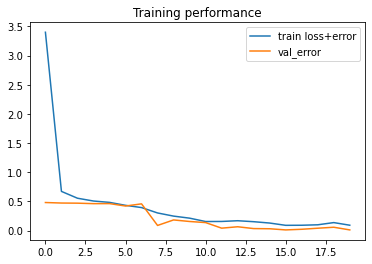

In [17]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

### Plot a confusion matrix of the model's performance.

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.99502488 0.00497512 0.        ]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]
['Cpm', 'Gaussian', 'Exponential']


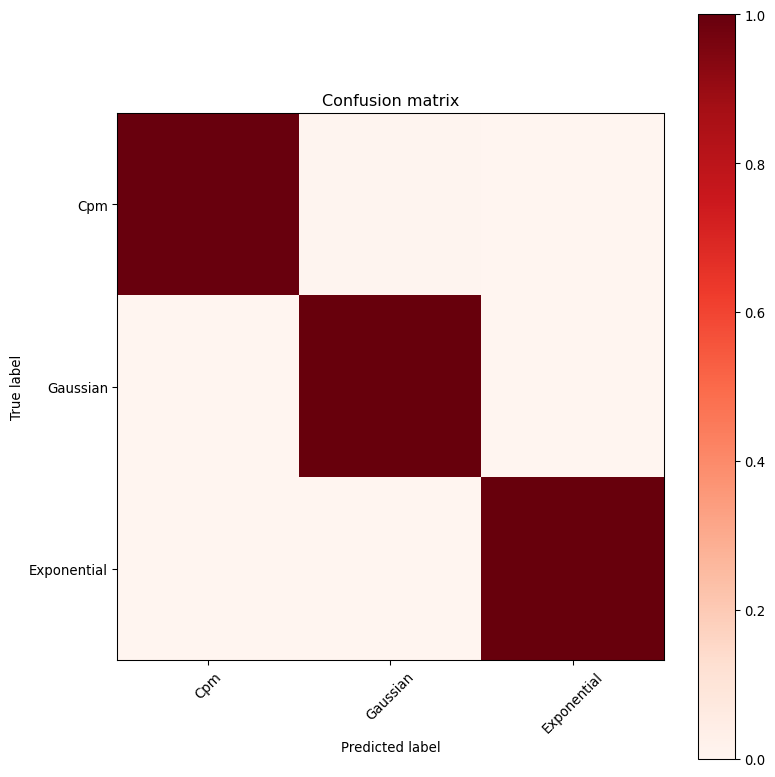

In [19]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

### Compute the model's accuracy.

In [20]:
cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
acc = 1.0*cor/(cor+ncor)
print (acc)

0.9983416252072969


### Conclusions

The TensorFlow predictive model trained here has an accuracy of about 99% for classifying data into normal CPM data, Gaussian random data, and exponential random data.